# Facemask_Detection

### Importing Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import os
import cv2

### Preprocessing the training set

### Preprocessing the test set

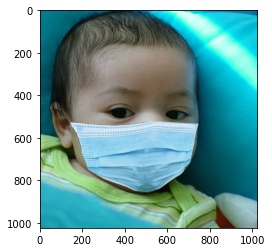

In [2]:
Datadirectory = "dataset/"
Classes = ["correct_mask" , "incorrect"]
for i in Classes:
    path = os.path.join(Datadirectory , i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array , cv2.COLOR_BGR2RGB))
        plt.show()
        break;
    break;

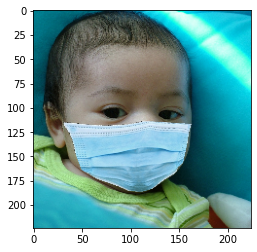

In [3]:
new_array = cv2.resize(img_array , (224,224))
plt.imshow(cv2.cvtColor(new_array , cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'correct_mask': 0, 'incorrect': 1}
['correct_mask', 'incorrect']
[0, 1]


In [5]:
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
def create():
    for imagePath in imagePaths:

        label = imagePath.split(os.path.sep)[-2]
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(label)

In [6]:
create()

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
print(data.shape)
print(labels.shape)

print(data[0:5])
print(labels)

(1950, 224, 224, 3)
(1950,)
[[[[-0.9843137   0.05098045  0.1686275 ]
   [-1.         -0.00392157  0.12941182]
   [-1.          0.01176476  0.12156868]
   ...
   [-0.99215686 -0.06666666  0.21568632]
   [-1.         -0.09803921  0.19215691]
   [-1.         -0.09019607  0.1686275 ]]

  [[-0.99215686  0.0196079   0.1686275 ]
   [-1.         -0.00392157  0.12941182]
   [-1.          0.01176476  0.13725495]
   ...
   [-1.         -0.11372548  0.17647064]
   [-1.         -0.11372548  0.17647064]
   [-1.         -0.10588235  0.17647064]]

  [[-1.          0.0196079   0.14509809]
   [-0.9843137   0.01176476  0.12941182]
   [-1.         -0.00392157  0.09803927]
   ...
   [-1.         -0.12156862  0.1686275 ]
   [-0.99215686 -0.11372548  0.18431377]
   [-0.99215686 -0.11372548  0.20000005]]

  ...

  [[-0.8352941   0.19215691  0.33333337]
   [-0.8117647   0.21568632  0.35686278]
   [-0.8352941   0.19215691  0.33333337]
   ...
   [-0.00392157  0.21568632  0.22352946]
   [ 0.02745104  0.22352946  

### Building CNN

In [9]:
data.shape

(1950, 224, 224, 3)

In [10]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
input_shape=(224, 224, 3))

headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(7, 7))(headModel)

headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)

headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [11]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=5)

In [13]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Training CNN on Training set

In [15]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
hist = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),validation_steps=len(testX) // BS, epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


C:\Users\Xyron\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
48/48 [==============================] - 49s 945ms/step - loss: 0.3992 - accuracy: 0.8639 - val_loss: 0.1201 - val_accuracy: 0.9974
Epoch 2/20
48/48 [==============================] - 40s 835ms/step - loss: 0.1131 - accuracy: 0.9869 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 3/20
48/48 [==============================] - 41s 848ms/step - loss: 0.0550 - accuracy: 0.9935 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 4/20
48/48 [==============================] - 41s 860ms/step - loss: 0.0416 - accuracy: 0.9941 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 5/20
48/48 [==============================] - 43s 890ms/step - loss: 0.0276 - accuracy: 0.9948 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 6/20
48/48 [==============================] - 43s 892ms/step - loss: 0.0249 - accuracy: 0.9941 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 7/20
48/48 [==============================] - 43s 891ms/step - loss: 0.0212 - accuracy: 0.9961 - val_loss: 0.0068 - val_accuracy: 1.0000

In [16]:
model.save('final_model.h5')

C:\Users\Xyron\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Visualizing results

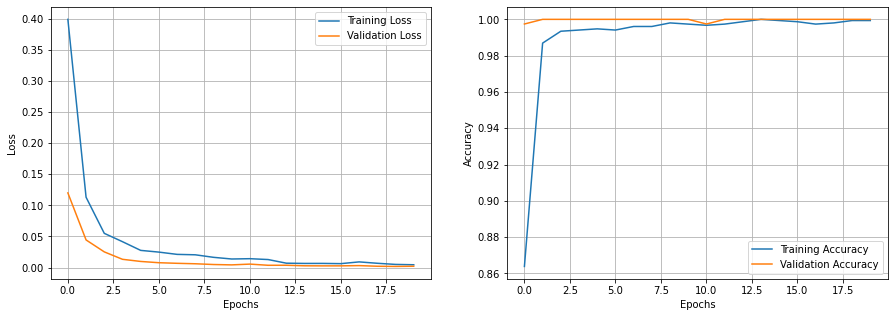

In [17]:
plt.figure(1, figsize = (15, 5))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( hist.history["loss"], label = "Training Loss")
plt.plot( hist.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( hist.history["accuracy"], label = "Training Accuracy")
plt.plot( hist.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## Checking model for Predictions

In [18]:
img = cv2.imread('women.jpg')

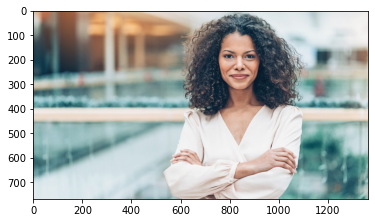

In [19]:
plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))

In [20]:
# gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
resized=cv2.resize(img,(224,224))
normalized=resized/255.0
reshaped=np.reshape(normalized,(1,224,224,3))

In [21]:
Predictions = model.predict(reshaped)
print(Predictions)

[[0.45361307 0.54638696]]


In [22]:
print(Predictions[0][0])
print(Predictions[0][1])

0.45361307
0.54638696


In [23]:
img2 = cv2.imread('women2.jpeg')

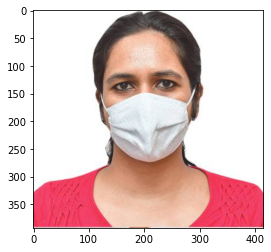

In [24]:
plt.imshow(cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB))

In [25]:
# gray=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)    
resized=cv2.resize(img2,(224,224))
normalized=resized/255.0
reshaped=np.reshape(normalized,(1,224,224,3))

In [26]:
Predictions = model.predict(reshaped)
print(Predictions)

[[9.999999e-01 1.428922e-07]]


## Face Detection

In [27]:
img3 = cv2.imread('women3.jfif')

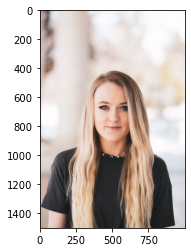

In [28]:
plt.imshow(cv2.cvtColor(img3 , cv2.COLOR_BGR2RGB))

In [29]:
face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [30]:
gray = cv2.cvtColor(img3 , cv2.COLOR_BGR2GRAY)

In [31]:
gray.shape

(1500, 1000)

In [32]:
faces = face.detectMultiScale(gray,1.1,4)
for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img3[y:y+h , x:x+w]
        cv2.rectangle(img3,(x,y),(x+w,y+h),(0,0,255),2)       
        face2 = face.detectMultiScale(roi_gray)
        if(len(face2) == 0):
            print("No Face")
        else:
            for (ex,ey,ew,eh) in face2:
                face_roi = roi_color[ey:ey+eh,ex:ex+ew]

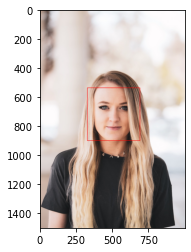

In [33]:
plt.imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB))

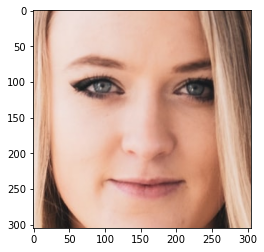

In [34]:
plt.imshow(cv2.cvtColor(face_roi , cv2.COLOR_BGR2RGB))

In [35]:
# gray=cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)    
resized=cv2.resize(img3,(224,224))
normalized=resized/255.0
reshaped=np.reshape(normalized,(1,224,224,3))

In [36]:
predictions = model.predict(reshaped)

In [37]:
print(predictions)

[[0.6372685 0.3627315]]
